# AI3000 : Reinforcement Learning <br>
# Assignment 2

Name : Ahmik Virani <br>
Roll Number ES22BTECH11001

## Problem 3 : Game of Tic-Tac-Toe

In [40]:
import random
import numpy as np
import matplotlib.pyplot as plt

### (a) Develop a Tic-Tac-Toe environment

In [41]:
class environment:
    # Initialization function
    def __init__(self):
        # Initialize an empty 3x3 board
        self.board = [[' ' for _ in range(3)] for _ in range(3)]

        # Assign the agent and opponent symbols
        self.agent_symbol = 'X'
        self.opponent_symbol = 'O'

        # An array to keep track of the empty cells
        # We order in row-major format, 0 based indexing
        self.empty_cells = [0, 1, 2, 3, 4, 5, 6, 7, 8]

    # input a move suggested by the agent. The form of cell number
    def act(self, cell_number, symbol):
        # Check if that cell is already taken
        if cell_number not in self.empty_cells:
            return False

        # Remove that cell from the empty cells list
        self.empty_cells.remove(cell_number)

        # Assign the agent symbol to that cell
        row = cell_number // 3
        col = cell_number % 3
        self.board[row][col] = symbol

        # Return true indicating that move was successful
        return True

    # Print the board
    def print(self):
        for row in range(3):
            for col in range(3):
                print(self.board[row][col], end='')
                if(col < 2):
                    print('|', end='')
            if(row < 2):
                print("\n-----")
    
    # A function that returns the currect state of the board in the form of a string
    def state(self):
        state = ''
        for row in range(3):
            for col in range(3):
                state += self.board[row][col]
        return state

    # A function that returns 1 if the agent wins
    # returns -1 if the opponent wins
    # returns 0 otherwise
    def reward(self):
        # First check if any of the rows there is a win
        for row in range(3):
            if self.board[row][0] == self.board[row][1] == self.board[row][2] != ' ':
                if self.board[row][0] == self.agent_symbol:
                    return 1
                else:
                    return -1

        # Next check if any column has a win
        for col in range(3):
            if self.board[0][col] == self.board[1][col] == self.board[2][col] != ' ':
                if self.board[0][col] == self.agent_symbol:
                    return 1
                else:
                    return -1

        # Next check the first diagonal
        if self.board[0][0] == self.board[1][1] == self.board[2][2] != ' ':
            if self.board[0][0] == self.agent_symbol:
                return 1
            else:
                return -1
                
        # Next check the second diagonal
        if self.board[0][2] == self.board[1][1] == self.board[2][0] != ' ':
            if self.board[0][2] == self.agent_symbol:
                return 1
            else:
                return -1
        

        # If no one has won
        return 0

    # A function to check if game is over
    def gameOver(self):
        # If there are no more cells left, then game is over
        if(len(self.empty_cells) == 0):
            return True
        
        # If any player has won, then game is over
        if self.reward() != 0:
            return True

        # Otherwise the game continues
        return False

### (b) Develop two opponents for the Q-learning agent

In [42]:
class randomAgent:
    # Initialization function
    # We pass the environment it interacts with
    def __init__(self, env):
        self.env = env

    # Function to randomly take a move
    def takeMove(self):
        # We know that we have a list of empty cells
        # Thus we will uniformly randomly select one from cell it
        random_cell = random.choice(self.env.empty_cells)
        
        # We take the action
        self.env.act(random_cell, self.env.opponent_symbol)

In [43]:
class safeAgent:
    # Initialization function
    # We pass the environment it interacts with
    def __init__(self, env):
        self.env = env

    # A function to check if winning move is available at given cell
    def checkWinningMove(self, cell_number, symbol):

        row = cell_number // 3
        col = cell_number % 3

        # First we check if it is a win in that row
        checkWinRow = True
        for c in range(3):
            if(c != col):
                if(self.env.board[row][c] != symbol):
                    checkWinRow = False
                    break

        # Next we check if it is a win in that column
        checkWinCol = True
        for r in range(3):
            if(r != row):
                if(self.env.board[r][col] != symbol):
                    checkWinCol = False
                    break

        # Next we check win on first diagonal
        checkWinDiag1 = True
        if(cell_number in [0, 4, 8]):
            for i in range(3):
                if((i * 3 + i) != cell_number):
                    if(self.env.board[i][i] != symbol):
                        checkWinDiag1 = False
                        break
        # If this is not part of first diagonal, we cannot win from it anyway
        else:
            checkWinDiag1 = False

        # Next we check win on second diagonal
        checkWinDiag2 = True
        if(cell_number in [2, 4, 6]):
            for i, j in zip([0, 1, 2], [2, 1, 0]):
                if((i * 3 + j) != cell_number):
                    if(self.env.board[i][j] != symbol):
                        checkWinDiag2 = False
                        break
        # If this is not part of second diagonal, we cannot win from it anyway
        else:
            checkWinDiag2 = False

        # If any of the above is true, then it is a winning move
        return (checkWinRow or checkWinCol or checkWinDiag1 or checkWinDiag2)

    # Function to make 'safe' move as defined in the problem statement
    def takeMove(self):
        # First we check if there is a winning move available
        for cell in self.env.empty_cells:
            # If we can win using this cell, we take it
            if(self.checkWinningMove(cell, self.env.opponent_symbol)):
                self.env.act(cell, self.env.opponent_symbol)
                return

        # Next we check if there is a blocking move
        # This means that, in this immediate turn, the agent can win if we play with their symbol
        # So check if winning move for agent
        for cell in self.env.empty_cells:
            # If the agent can win using this cell, we take it to block
            if(self.checkWinningMove(cell, self.env.agent_symbol)):
                self.env.act(cell, self.env.opponent_symbol)
                return
                
        # If none of the above was done, then we take a random move
        random_cell = random.choice(self.env.empty_cells)
        self.env.act(random_cell, self.env.opponent_symbol)


### (c) The Q-learning agent

In [44]:
class qLearningAgent:
    # Initialization function
    # We pass the environment it interacts with
    def __init__(self, env):
        self.env = env

        # We need to define the Q-table
        # We take initial value to be 
        self.q_table = {}

    # A function to make a move epsilon greedy move based on the Q-table
    def takeMove(self, epsilon=0.1):
        # First we get the current state of the board from the environment
        current_state = self.env.state()

        # The action if to place an 'X' in any one of the empty cells

        # First check if the current state is in the Q-table
        # If not, then we initialize it
        if current_state not in self.q_table:
            self.q_table[current_state] = np.zeros(9)
            # We set the values of the non-empty cells to -inf, so that we never take those actions
            for cell in range(9):
                if cell not in self.env.empty_cells:
                    self.q_table[current_state][cell] = -np.inf

        # Take an epsilon greedy move
        if random.uniform(0, 1) < epsilon:
            # Take a random action with probability epsilon
            selected_action = random.choice(self.env.empty_cells)
        else:
            # We take the best possible action
            # In case of draws, we will arbitrary take any
            best_value = np.max(self.q_table[current_state])
            best_action = [action for action in self.env.empty_cells if self.q_table[current_state][action] == best_value]

            # We randomly select one of the best actions
            selected_action = random.choice(best_action)
        
        self.env.act(selected_action, self.env.agent_symbol)
        return selected_action

    # A function to update the Q-table
    def onlineLearning(self, state, action, reward, next_state, alpha=0.1, gamma=0.9):
        # First check if the new state is in the Q-table
        # If not, then initialize it
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
            empty_cells_for_next_state = [i for i, char in enumerate(next_state) if char == ' ']
            # We set the values of the non-empty cells to -inf, so that we never take those actions
            for cell in range(9):
                if cell not in empty_cells_for_next_state:
                    self.q_table[next_state][cell] = -np.inf

        # Next we will apply Watkin’s Q-learning update rule
        if(self.env.gameOver()):
            self.q_table[state][action] = self.q_table[state][action] + alpha * (reward - self.q_table[state][action])
        else:
            self.q_table[state][action] = self.q_table[state][action] + alpha * (reward + gamma * np.max(self.q_table[next_state]) - self.q_table[state][action])


### Writing code for training games and testing games

In [45]:
def training_games(agent, opponent, env):
    # We toss a coin to see who starts
    # If 1, then agents turn first, else opponent turn
    agents_turn = random.choice([0, 1])

    # Keep track of the agent's last state and action
    last_agent_state = None
    last_agent_action = None

    while(not env.gameOver()):
        if agents_turn:
            # Store the current state
            current_state = env.state()

            # If this isn't the agent's first move, we can now update the Q-table previous move. The reward for an intermediate move is 0.
            if last_agent_state is not None:
                agent.onlineLearning(last_agent_state, last_agent_action, 0, current_state)

            # Store the action taken
            action = agent.takeMove()

            last_agent_state = current_state
            last_agent_action = action

            # Change the turn
            agents_turn = 0
        else:
            # Opponent's turn
            opponent.takeMove()
            agents_turn = 1

    final_reward = env.reward()
    agent.onlineLearning(last_agent_state, last_agent_action, final_reward, env.state())

def testing_games(agent, opponent, env):
    # We toss a coin to see who starts
    # If 1, then agents turn first, else opponent turn
    agents_turn = random.choice([0, 1])

    while(not env.gameOver()):
        if agents_turn:
            # Store the current state
            current_state = env.state()

            # Store the action taken
            # Ensure during testing it is fully greedy
            action = agent.takeMove(epsilon=0)

            # Store the next state which we reach
            next_state = env.state()

            # No updation of the Q-table during testing phase

            # Change the turn
            agents_turn = 0
        else:
            # Opponent's turn
            opponent.takeMove()
            agents_turn = 1


# A dummy function to plot the graph of epochs vs wins
def plot_graph_epochs_vs_wins(win_counter, epochs):

    plt.plot(epochs, win_counter, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.xlabel("Number of Epochs")
    plt.ylabel("Number of Wins")
    plt.title("Number of Wins vs epochs")

    # Show the grid
    plt.grid(True)

    # Set the y limits from 0 to 100
    plt.ylim(0, 100)

    # Display the plot
    plt.show()

### (1) Training is done only against the random player. But the learnt Q-table is tested against both random and safe player.

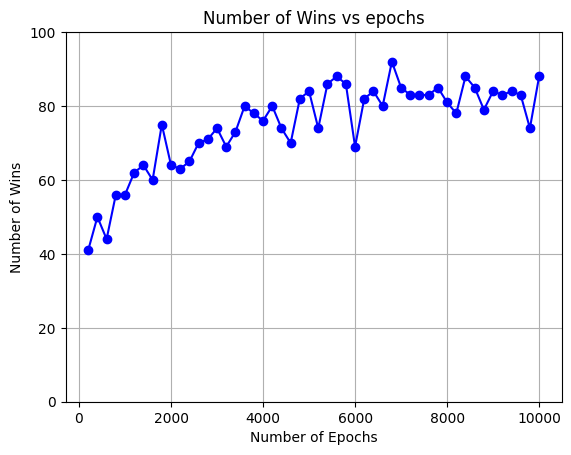

In [46]:
# Initialize all the environment and the agents
env = environment()
random_agent = randomAgent(env)
safe_agent = safeAgent(env)
q_learning_agent = qLearningAgent(env)

# We play 10000 games for training
games = 10000

# Keep track of wins after every 200 games
win_counter = []
for game in range(1, games + 1, 1):
    # We reset the environment every game
    env = environment()
    random_agent.env = env
    q_learning_agent.env = env

    # Train only against random agent
    training_games(q_learning_agent, random_agent, env)
    
    # After every 200 games, we test for 100 times
    if(game % 200 == 0):
        win_games = 0
        for test_game in range(100):
            env = environment()
            random_agent.env = env
            q_learning_agent.env = env

            # 100 testing games
            testing_games(q_learning_agent, random_agent, env)

            if(env.reward() == 1):
                win_games += 1
    
        win_counter.append(win_games)

# Make a plot of number of epochs vs wins
epochs = [i for i in range(200, games + 1, 200)]
plot_graph_epochs_vs_wins(win_counter, epochs)

win_counter_random = win_counter

Testing on the above

In [47]:
games = 1000

# First index stores games won against safe opponent, second against random opponent
win_games = np.zeros(2)
loss_games = np.zeros(2)
draw_games = np.zeros(2)

for game in range(games):
    env = environment()
    random_agent.env = env
    safe_agent.env = env
    q_learning_agent.env = env

    # All the odd games against random agent, even against safe agent
    if(game & 1):
        testing_games(q_learning_agent, random_agent, env)
    else:
        testing_games(q_learning_agent, safe_agent, env)
    
    # Check the result of each game
    if(env.reward() == 1):
        win_games[game & 1] += 1
    elif(env.reward() == -1):
        loss_games[game & 1] += 1
    else:
        draw_games[game & 1] += 1

print(f"Games won against random opponent : {win_games[1]}")
print(f"Games lost against random opponent: {loss_games[1]}")
print(f"Games drawn against random opponent: {draw_games[1]}")
print()
print(f"Games won against safe opponent : {win_games[0]}")
print(f"Games lost against safe opponent: {loss_games[0]}")
print(f"Games drawn against safe opponent: {draw_games[0]}")
print()
print(f"Total games won : {np.sum(win_games)}")
print(f"Total games lost: {np.sum(loss_games)}")
print(f"Total games drawn: {np.sum(draw_games)}")
print()
print(f"Win/Loss = {np.sum(win_games)/np.sum(loss_games)}")

Games won against random opponent : 420.0
Games lost against random opponent: 21.0
Games drawn against random opponent: 59.0

Games won against safe opponent : 91.0
Games lost against safe opponent: 187.0
Games drawn against safe opponent: 222.0

Total games won : 511.0
Total games lost: 208.0
Total games drawn: 281.0

Win/Loss = 2.456730769230769


### (2) Training is done only against the safe player. But the learnt Q-table is tested against both random and safe player.

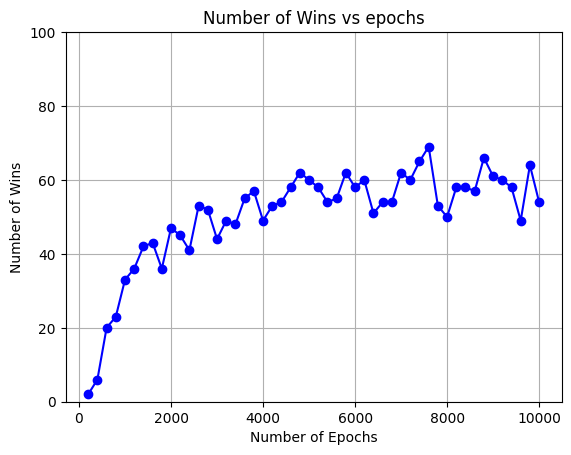

In [48]:
# Initialize all the environment and the agents
env = environment()
random_agent = randomAgent(env)
safe_agent = safeAgent(env)
q_learning_agent = qLearningAgent(env)

# We play 10000 games for training
games = 10000

# Keep track of wins after every 200 games
win_counter = []
for game in range(1, games + 1, 1):
    # We reset the environment every game
    env = environment()
    safe_agent.env = env
    q_learning_agent.env = env

    # Train only against safe agent
    training_games(q_learning_agent, safe_agent, env)

    # After every 200 games, we test for 100 times
    if(game % 200 == 0):
        win_games = 0
        for test_game in range(100):
            env = environment()
            safe_agent.env = env
            q_learning_agent.env = env

            # All the odd games against random agent, even against safe agent
            testing_games(q_learning_agent, safe_agent, env)
            
            # Check the result of each game
            if(env.reward() == 1):
                win_games += 1

        win_counter.append(win_games)

# Make a plot of number of epochs vs wins
epochs = [i for i in range(200, games + 1, 200)]
plot_graph_epochs_vs_wins(win_counter, epochs)

win_counter_safe = win_counter

Testing on the above

In [49]:
games = 1000

# First index stores games won against safe opponent, second against random opponent
win_games = np.zeros(2)
loss_games = np.zeros(2)
draw_games = np.zeros(2)

for game in range(games):
    env = environment()
    random_agent.env = env
    safe_agent.env = env
    q_learning_agent.env = env

    # All the odd games against random agent, even against safe agent
    if(game & 1):
        testing_games(q_learning_agent, random_agent, env)
    else:
        testing_games(q_learning_agent, safe_agent, env)
    
    # Check the result of each game
    if(env.reward() == 1):
        win_games[game & 1] += 1
    elif(env.reward() == -1):
        loss_games[game & 1] += 1
    else:
        draw_games[game & 1] += 1

print(f"Games won against random opponent : {win_games[1]}")
print(f"Games lost against random opponent: {loss_games[1]}")
print(f"Games drawn against random opponent: {draw_games[1]}")
print()
print(f"Games won against safe opponent : {win_games[0]}")
print(f"Games lost against safe opponent: {loss_games[0]}")
print(f"Games drawn against safe opponent: {draw_games[0]}")
print()
print(f"Total games won : {np.sum(win_games)}")
print(f"Total games lost: {np.sum(loss_games)}")
print(f"Total games drawn: {np.sum(draw_games)}")
print()
print(f"Win/Loss = {np.sum(win_games)/np.sum(loss_games)}")

Games won against random opponent : 307.0
Games lost against random opponent: 83.0
Games drawn against random opponent: 110.0

Games won against safe opponent : 295.0
Games lost against safe opponent: 32.0
Games drawn against safe opponent: 173.0

Total games won : 602.0
Total games lost: 115.0
Total games drawn: 283.0

Win/Loss = 5.234782608695652


### (3) In every game of training, we randomly select our opponent. The learnt Q-table is tested against both random and safe player.

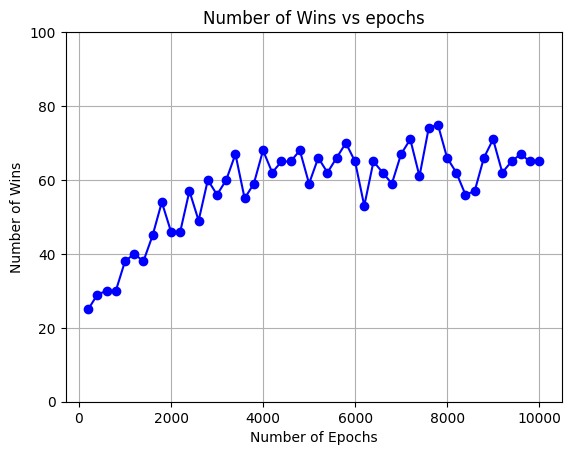

In [50]:
# Initialize all the environment and the agents
env = environment()
random_agent = randomAgent(env)
safe_agent = safeAgent(env)
q_learning_agent = qLearningAgent(env)

# We play 10000 games for training
games = 10000

# Keep track of wins after every 200 games
win_counter = []
for game in range(1, games + 1, 1):
    # We reset the environment every game
    env = environment()
    random_agent.env = env
    safe_agent.env = env
    q_learning_agent.env = env

    # Train randomly against either random agent or safe agent
    if(random.choice([0, 1]) == 1):
        training_games(q_learning_agent, random_agent, env)
    else:
        training_games(q_learning_agent, safe_agent, env)

    # After every 200 games, we test for 100 times
    if(game % 200 == 0):
        win_games = 0
        for test_game in range(100):
            env = environment()
            random_agent.env = env
            safe_agent.env = env
            q_learning_agent.env = env

            # All the odd games against random agent, even against safe agent
            if(test_game & 1):
                testing_games(q_learning_agent, random_agent, env)
            else:
                testing_games(q_learning_agent, safe_agent, env)
            
            # Check the result of each game
            if(env.reward() == 1):
                win_games += 1

        win_counter.append(win_games)

# Make a plot of number of epochs vs wins
epochs = [i for i in range(200, games + 1, 200)]
plot_graph_epochs_vs_wins(win_counter, epochs)

win_counter_both = win_counter

Testing on the above

In [51]:
games = 1000

# First index stores games won against safe opponent, second against random opponent
win_games = np.zeros(2)
loss_games = np.zeros(2)
draw_games = np.zeros(2)

for game in range(games):
    env = environment()
    random_agent.env = env
    safe_agent.env = env
    q_learning_agent.env = env

    # All the odd games against random agent, even against safe agent
    if(game & 1):
        testing_games(q_learning_agent, random_agent, env)
    else:
        testing_games(q_learning_agent, safe_agent, env)
    
    # Check the result of each game
    if(env.reward() == 1):
        win_games[game & 1] += 1
    elif(env.reward() == -1):
        loss_games[game & 1] += 1
    else:
        draw_games[game & 1] += 1

print(f"Games won against random opponent : {win_games[1]}")
print(f"Games lost against random opponent: {loss_games[1]}")
print(f"Games drawn against random opponent: {draw_games[1]}")
print()
print(f"Games won against safe opponent : {win_games[0]}")
print(f"Games lost against safe opponent: {loss_games[0]}")
print(f"Games drawn against safe opponent: {draw_games[0]}")
print()
print(f"Total games won : {np.sum(win_games)}")
print(f"Total games lost: {np.sum(loss_games)}")
print(f"Total games drawn: {np.sum(draw_games)}")
print()
print(f"Win/Loss = {np.sum(win_games)/np.sum(loss_games)}")

Games won against random opponent : 410.0
Games lost against random opponent: 17.0
Games drawn against random opponent: 73.0

Games won against safe opponent : 270.0
Games lost against safe opponent: 41.0
Games drawn against safe opponent: 189.0

Total games won : 680.0
Total games lost: 58.0
Total games drawn: 262.0

Win/Loss = 11.724137931034482


### Overall training comparision

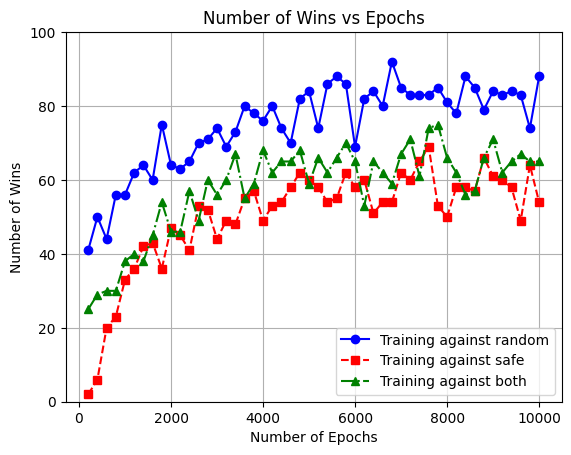

In [52]:
# Plot all three training graphs made earlier
plt.plot(epochs, win_counter_random, marker='o', linestyle='-', color='b', label='Training against random')
plt.plot(epochs, win_counter_safe, marker='s', linestyle='--', color='r', label='Training against safe')
plt.plot(epochs, win_counter_both, marker='^', linestyle='-.', color='g', label='Training against both')

plt.xlabel("Number of Epochs")
plt.ylabel("Number of Wins")
plt.title("Number of Wins vs Epochs")

plt.ylim(0, 100)

plt.legend()
plt.grid(True)

plt.show()

### Overall Testing Comparision

### (4) Among the three agents developed, which agent is best ? Why ?

Training on random agent
- Total games won : 511.0
- Total games lost: 208.0
- Total games drawn: 281.0
- Win/Loss = 2.456730769230769

Training on safe agent
- Total games won : 602.0
- Total games lost: 115.0
- Total games drawn: 283.0
- Win/Loss = 5.234782608695652

Training on both 
- Total games won : 680.0
- Total games lost: 58.0
- Total games drawn: 262.0
- Win/Loss = 11.724137931034482

- The best according to me is the agent which won the most games and lost the least. After taking the ratio, I have come to the conclusion that the agent which was trained on both actually has the best ratio. Therefore I come to the conclusion that this is the best agent.

- Now the reason this may be the case is as follows: 
1. The agent trained against random agent never learnt to be defensive and thus could not stop the winning of safe agent. On the contrary, it would be stopped by the safe agent.
2. The agent trained only against a safe opponent learns a predictable, defensive strategy but may not be exposed to the wide variety of unusual board states that a random opponent can create.

- Thus the agent trained on both got the best of both worlds

### (5) Is the Q-learning agent developed unbeatable against any possible opponent ? If not, suggest ways to improve the training process.

- In a game of tic-tac-toe, a perfect opponent will never lose. Therefore, the agent in not unbeatable. 
- Let us say that we play against a deterministic opponent, then we could make the agent learn to counter it and not lose
- However, its knowledge is incomplete, it has not learned the optimal action for every possible board state, as it was trained for a limited number of games against non-perfect players.

Hence, No, the agent is not unbeatable.

A few ways to improve the same:
1. Use a decaying epsilon, because as the number of samples increase, we have done enough exploration and need to do exploitation
2. More training so it can observe more state action pairs
3. Optimal play - Train against the best agent
4. Self play - Play against itself so it learns to overcome its defeciencies in a way
5. Hyperparameter (alpha, gamma, epsilon) tuning may help